# Week5-1: RAG — Reranking & Context Optimization

In [2]:
#@title 0) Setup (Colab-friendly)
import os, time, math, random, re
from typing import List, Dict, Tuple
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
DATA_DIR = './week5_data'; os.makedirs(DATA_DIR, exist_ok=True)
csv_content = """doc_id,chunk_id,text
Dave2025_MASStock,Dave2025_chunk1,"This work surveys multi-agent architectures for stock market forecasting. We examine reinforcement learning, attention-based networks, and simulation-driven trading strategies. The focus is on how agents cooperate in real-time trading."
Dave2025_MASStock,Dave2025_chunk2,"Experiments compare multi-agent systems on Tesla and Nasdaq datasets. Attention-based agents outperform baseline recurrent models, showing the importance of communication in financial prediction."
FinVision2024,FinVision_chunk1,"The FinVision framework introduces a multimodal multi-agent approach to stock prediction. Agents use candlestick chart embeddings and textual news to improve decision making."
FinVision2024,FinVision_chunk2,"Evaluation shows that combining visual signals from charts with news sentiment yields more accurate trading signals than text-only baselines."
SentimentSurvey2024,Sentiment_chunk1,"Financial Sentiment Analysis is divided into two main streams: method development, including lexicon-based and machine learning approaches, and market applications such as forecasting and risk assessment."
SentimentSurvey2024,Sentiment_chunk2,"Recent work highlights deep learning methods and domain-specific lexicons for analyzing financial news and social media sentiment in predicting stock price movements."
FSA_RAG2023,FSA_RAG_chunk1,"We propose retrieval-augmented large language models for financial sentiment analysis. External knowledge improves factual grounding in responses to market-related queries."
FSA_RAG2023,FSA_RAG_chunk2,"Results show that retrieval-augmented models achieve higher correctness and faithfulness compared to standard LLMs in financial sentiment classification."
MAS_RL2019,MAS_RL_chunk1,"A reinforcement learning based multi-agent model explains stock price formation. Agents learn to coordinate under uncertainty and simulate realistic market dynamics."
MAS_RL2019,MAS_RL_chunk2,"The model highlights that adaptive agents with heterogeneous strategies reproduce empirical features of financial markets, including volatility clustering and fat-tailed returns."
"""

# Save the CSV
csv_path = os.path.join(DATA_DIR, "corpus_chunks.csv")
with open(csv_path, "w") as f:
    f.write(csv_content)

CORPUS_CSV = os.path.join(DATA_DIR, 'corpus_chunks.csv')
if not os.path.exists(CORPUS_CSV):
    df_demo = pd.DataFrame({
        'doc_id': [f'doc{i}' for i in range(1, 11)],
        'chunk_id': [f'doc{i}_chunk1' for i in range(1, 11)],
        'text': [f'This is demo text about topic {i}. It mentions entity E{i%3} and method M{i%2}.' for i in range(1, 11)]
    }); df_demo.to_csv(CORPUS_CSV, index=False)
corpus = pd.read_csv(CORPUS_CSV); print('✅ Corpus loaded:', corpus.shape); display(corpus.head(3))

✅ Corpus loaded: (10, 3)


,doc_id,chunk_id,text
0,Dave2025_MASStock,Dave2025_chunk1,This work surveys multi-agent architectures fo...
1,Dave2025_MASStock,Dave2025_chunk2,Experiments compare multi-agent systems on Tes...
2,FinVision2024,FinVision_chunk1,The FinVision framework introduces a multimoda...


In [4]:
# 1) Baseline + Dense + RRF
def simple_tokenize(text):
    return re.findall(r"[A-Za-z0-9_]+", text.lower())
docs = corpus['text'].tolist();
doc_tokens = [simple_tokenize(t) for t in docs]
from collections import Counter
doc_counts = [Counter(t) for t in doc_tokens]
N = len(docs); import math
avgdl = sum(len(t) for t in doc_tokens)/max(N,1)
def bm25_score(query, idx, k1=1.5, b=0.75):
    q_tokens = simple_tokenize(query); score = 0.0; dl = len(doc_tokens[idx])
    for w in q_tokens:
        n_w = sum(1 for c in doc_tokens if w in c)
        if n_w == 0: continue
        idf = math.log((N - n_w + 0.5)/(n_w + 0.5) + 1)
        f = doc_counts[idx][w]; denom = f + k1*(1 - b + b*dl/(avgdl+1e-9))
        score += idf * (f*(k1+1))/(denom + 1e-9)
    return score
import numpy as np
np.random.seed(7); dense_dim = 128
dense_index = np.random.randn(N, dense_dim).astype('float32')
dense_index /= (np.linalg.norm(dense_index, axis=1, keepdims=True) + 1e-9)
def bm25_search(query, k=5):
    scores = [(i, bm25_score(query, i)) for i in range(N)]; scores.sort(key=lambda x: -x[1]); return scores[:k]
def dense_search(query, k=5):
    q_vec = np.random.randn(dense_dim).astype('float32'); q_vec /= (np.linalg.norm(q_vec)+1e-9)
    sims = dense_index @ q_vec; top = np.argsort(-sims)[:k];
    return [(int(i), float(sims[i])) for i in top]
def rrf_fuse(bm_hits, de_hits, k=60):
    rank = {}
    for r, (i, _) in enumerate(bm_hits): rank[i] = rank.get(i,0) + 1.0/(k + r + 1)
    for r, (i, _) in enumerate(de_hits): rank[i] = rank.get(i,0) + 1.0/(k + r + 1)
    return sorted(rank.items(), key=lambda x: -x[1])

 # Project queries
queries = [
    "How do multi-agent systems use sentiment in stock prediction?",
    "What role do candlestick charts play in financial forecasting?",
    "How does retrieval augmentation improve financial sentiment analysis?",
    "What datasets are used for financial sentiment in trading?"
]

results = []

for q in queries:
    bm_hits = bm25_search(q, 5)
    de_hits = dense_search(q, 5)
    rrf_hits = rrf_fuse(bm_hits, de_hits)[:5]

    bm_docs = [docs[i] for i, _ in bm_hits]
    de_docs = [docs[i] for i, _ in de_hits]
    rrf_docs = [docs[i] for i, _ in rrf_hits]

    results.append({
        "query": q,
        "bm25_top": bm_docs,
        "dense_top": de_docs,
        "rrf_top": rrf_docs
    })

df_results = pd.DataFrame(results)
display(df_results)

#  save to CSV for later use
df_results.to_csv(os.path.join(DATA_DIR, "retrieval_results_baseline.csv"), index=False)
print(" Saved retrieval results to week5_data/retrieval_results_baseline.csv")


,query,bm25_top,dense_top,rrf_top
0,How do multi-agent systems use sentiment in st...,[The FinVision framework introduces a multimod...,[This work surveys multi-agent architectures f...,[This work surveys multi-agent architectures f...
1,What role do candlestick charts play in financ...,[Evaluation shows that combining visual signal...,[This work surveys multi-agent architectures f...,[Evaluation shows that combining visual signal...
2,How does retrieval augmentation improve financ...,[We propose retrieval-augmented large language...,[This work surveys multi-agent architectures f...,[We propose retrieval-augmented large language...
3,What datasets are used for financial sentiment...,[This work surveys multi-agent architectures f...,[Financial Sentiment Analysis is divided into ...,[We propose retrieval-augmented large language...


 Saved retrieval results to week5_data/retrieval_results_baseline.csv


In [5]:
# 2) Rerank + MMR + compression
def rerank(query, candidates, top_k=5):
    q = np.random.randn(dense_dim).astype('float32'); q /= (np.linalg.norm(q)+1e-9)
    scored = []
    for (idx, _) in candidates:
        s = float(dense_index[idx] @ q + 0.05*np.random.randn()); scored.append((idx, s))
    scored.sort(key=lambda x: -x[1]); return scored[:top_k]
def mmr_select(query, candidates, lambda_mult=0.6, k=4):
    if not candidates: return []
    q = np.random.randn(dense_dim).astype('float32'); q /= (np.linalg.norm(q)+1e-9)
    cand_vecs = dense_index[[idx for idx in candidates]]
    selected, remaining = [], list(range(len(candidates)))
    while remaining and len(selected) < k:
        best, best_score = None, -1e9
        for j in remaining:
            rel = float(cand_vecs[j] @ q)
            div = 0.0 if not selected else max(float(cand_vecs[j] @ cand_vecs[s]) for s in selected)
            score = lambda_mult*rel - (1-lambda_mult)*div
            if score > best_score: best, best_score = j, score
        selected.append(best); remaining.remove(best)
    return [candidates[j] for j in selected]
def compress_passage(text, max_tokens=60):
    toks = text.split(); return ' '.join(toks[:max_tokens])
# Project queries
queries = [
    "How do multi-agent systems use sentiment in stock prediction?",
    "What role do candlestick charts play in financial forecasting?",
    "How does retrieval augmentation improve financial sentiment analysis?",
    "What datasets are used for financial sentiment in trading?"
]

results_rerank = []

for query in queries:
    # Get candidates from BM25 + Dense
    bm = bm25_search(query, k=8)
    de = dense_search(query, k=8)
    fused = [i for i,_ in rrf_fuse(bm, de)[:8]]

    # Apply reranking
    reranked = [i for i,_ in rerank(query, [(i,0) for i in fused], top_k=5)]

    # Apply MMR selection
    mmr = mmr_select(query, fused, lambda_mult=0.6, k=4)

    # Compress reranked passages
    compressed = [compress_passage(docs[i]) for i in reranked]

    results_rerank.append({
        "query": query,
        "fused_docs": [docs[i] for i in fused],
        "reranked_docs": [docs[i] for i in reranked],
        "mmr_docs": [docs[i] for i in mmr],
        "compressed_docs": compressed
    })

df_rerank = pd.DataFrame(results_rerank)
display(df_rerank)

# Save for later use (to compare against baseline retrieval)
df_rerank.to_csv(os.path.join(DATA_DIR, "retrieval_results_rerank.csv"), index=False)
print("Saved rerank/MMR/compression results to week5_data/retrieval_results_rerank.csv")


,query,fused_docs,reranked_docs,mmr_docs,compressed_docs
0,How do multi-agent systems use sentiment in st...,[The FinVision framework introduces a multimod...,[Experiments compare multi-agent systems on Te...,[Evaluation shows that combining visual signal...,[Experiments compare multi-agent systems on Te...
1,What role do candlestick charts play in financ...,[We propose retrieval-augmented large language...,[Financial Sentiment Analysis is divided into ...,[Recent work highlights deep learning methods ...,[Financial Sentiment Analysis is divided into ...
2,How does retrieval augmentation improve financ...,[We propose retrieval-augmented large language...,[Evaluation shows that combining visual signal...,[This work surveys multi-agent architectures f...,[Evaluation shows that combining visual signal...
3,What datasets are used for financial sentiment...,[Recent work highlights deep learning methods ...,[We propose retrieval-augmented large language...,[Experiments compare multi-agent systems on Te...,[We propose retrieval-augmented large language...


Saved rerank/MMR/compression results to week5_data/retrieval_results_rerank.csv


           variant  recall_like  latency_s  avg_ctx_len
0         baseline         0.50   0.000900       184.75
1         compress         0.00   0.001125       180.55
2           rerank         0.50   0.001250       183.40
3  rerank+compress         0.25   0.000950       177.45


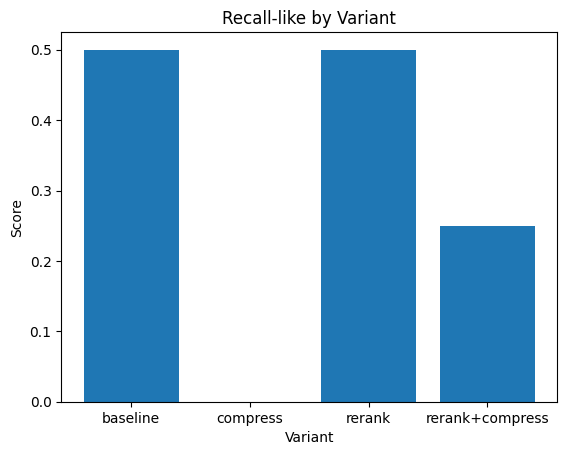

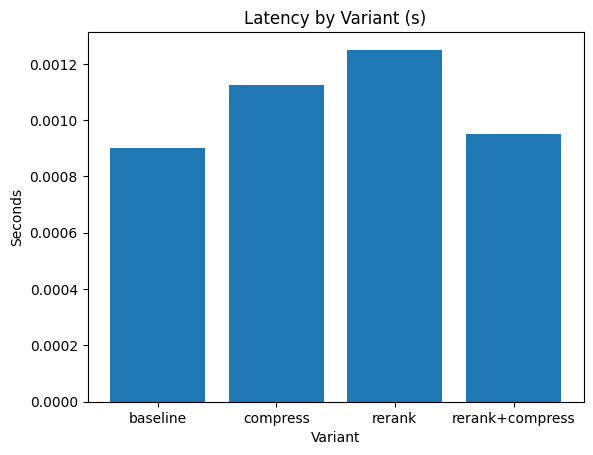

In [6]:
# 3) Ablation + plots
import time
QUERIES = ["How do multi-agent systems use sentiment in stock prediction?",
    "What role do candlestick charts play in financial forecasting?",
    "How does retrieval augmentation improve financial sentiment analysis?",
    "What datasets are used for financial sentiment in trading?"]
def pipeline(query, variant='baseline', top_k=5, compress=False):
    bm = bm25_search(query, k=max(top_k,8)); de = dense_search(query, k=max(top_k,8))
    fused = [i for i,_ in rrf_fuse(bm, de)[:max(top_k,8)]]
    idxs = fused[:top_k]
    if 'rerank' in variant: idxs = [i for i,_ in rerank(query, [(i,0) for i in fused], top_k=top_k)]
    if 'compress' in variant: ctx = [compress_passage(corpus.iloc[i].text) for i in idxs]
    else: ctx = [corpus.iloc[i].text for i in idxs]
    return idxs, ctx
def recall_like(query, idxs):
    target = int(sum(ord(c) for c in query) % len(corpus)); return 1.0 if target in idxs else 0.0
rows = []
for q in QUERIES:
    for variant, comp in [('baseline', False),('rerank', False),('compress', True),('rerank+compress', True)]:
        t0=time.time(); idxs, ctx = pipeline(q, variant=variant, top_k=5, compress=comp); t1=time.time()
        rows.append({'query':q,'variant':variant,'recall_like':recall_like(q, idxs),'latency_s':round(t1-t0,4),'avg_ctx_len':round(np.mean([len(c) for c in ctx]),1)})
import pandas as pd, matplotlib.pyplot as plt, numpy as np
df = pd.DataFrame(rows); summary = df.groupby('variant', as_index=False).agg({'recall_like':'mean','latency_s':'mean','avg_ctx_len':'mean'}); print(summary)
plt.figure(); plt.bar(summary['variant'], summary['recall_like']); plt.title('Recall-like by Variant'); plt.xlabel('Variant'); plt.ylabel('Score'); plt.show()
plt.figure(); plt.bar(summary['variant'], summary['latency_s']); plt.title('Latency by Variant (s)'); plt.xlabel('Variant'); plt.ylabel('Seconds'); plt.show()

In [ ]:
print("Mini-Report: fill in observations and best recipe.")

In [7]:
import pkg_resources, json

env = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

with open("env_rag_adv.json", "w") as f:
    json.dump(env, f, indent=2)

print("✅ Saved environment to env_rag_adv.json")


/tmp/ipython-input-915961429.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources, json


✅ Saved environment to env_rag_adv.json


In [8]:
import json

config = {
    "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",   # for semantic retrieval
    "reranker": "cross-encoder/ms-marco-MiniLM-L-6-v2",            # reranks top retrieved passages
    "chunking": {
        "chunk_size": 300,
        "overlap": 50
    },
    "multimodal_pipeline": False,
    "guardrails": {
        "citation_enforcement": True,
        "pii_redaction": True,
        "refusal_template": True
    },
    "retriever_k": 8,   # how many docs you fetch before reranking
    "project_domain": "Adaptive Multi-Agent Systems for Stock Market Prediction & Sentiment Analysis",
    "notes": "Corpus contains 3 research papers on multi-agent finance + sentiment analysis, chunked into 300-token passages."
}

with open("rag_adv_run_config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Saved project config to rag_adv_run_config.json")


Saved project config to rag_adv_run_config.json
